In [7]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [8]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [9]:
NUM_CLASSES = 8

# Dataset reading

In [10]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [11]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [14]:
import pydot
from tensorflow.keras.utils import plot_model
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout (Dropout)               │ (None, 42)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           860 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            88 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,158 (4.52 KB)

 Trainable params: 1,158 (4.52 KB)

 Non-trainable params: 0 (0.00 B)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [15]:
# Model checkpoint callback
model_save_path = "model/keypoint_classifier/keypoint_classifier.keras"
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [16]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [17]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 7/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1227 - loss: 2.1871
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.1294 - loss: 2.1182 - val_accuracy: 0.1678 - val_loss: 2.0067
Epoch 2/1000
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.1172 - loss: 2.0426
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1658 - loss: 2.0186 - val_accuracy: 0.2164 - val_loss: 1.9433
Epoch 3/1000
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1797 - loss: 1.9686
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1742 - loss: 1.9645 - val_accuracy: 0.2232 - val_loss: 1.8953
Epoch 4/1000
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 1.9514
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras

In [18]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9060 - loss: 0.4198 


In [19]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [20]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[1.4622458e-05 5.4713923e-06 3.8045529e-02 9.6120805e-01 1.2655092e-05
 6.9180218e-04 2.1900310e-05 1.3145859e-10]
3


# Confusion matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


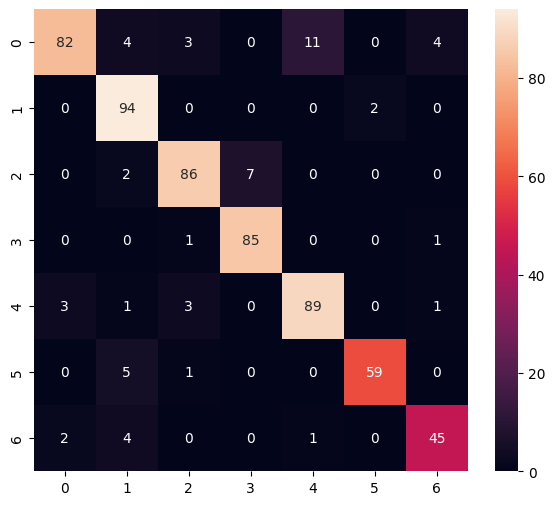

Classification Report
              precision    recall  f1-score   support

           0       0.94      0.79      0.86       104
           1       0.85      0.98      0.91        96
           2       0.91      0.91      0.91        95
           3       0.92      0.98      0.95        87
           4       0.88      0.92      0.90        97
           5       0.97      0.91      0.94        65
           6       0.88      0.87      0.87        52

    accuracy                           0.91       596
   macro avg       0.91      0.91      0.91       596
weighted avg       0.91      0.91      0.91       596



In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [22]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [23]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\91916\AppData\Local\Temp\tmphrl_gq23\assets


INFO:tensorflow:Assets written to: C:\Users\91916\AppData\Local\Temp\tmphrl_gq23\assets


Saved artifact at 'C:\Users\91916\AppData\Local\Temp\tmphrl_gq23'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  2221584275536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2221584277456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2221584285520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2221584284944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2221584285136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2221584282640: TensorSpec(shape=(), dtype=tf.resource, name=None)


6732

# Inference test

In [24]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

c:\Users\91916\Desktop\handgesture detection\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [25]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [26]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [27]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 0 ns


In [28]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.4622485e-05 5.4714078e-06 3.8045563e-02 9.6120799e-01 1.2655103e-05
 6.9180410e-04 2.1900329e-05 1.3145884e-10]
3
